## Import packages

In [1]:
import gzip
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
sns.set()
sns.set_context('talk')

In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        l = str(json.loads(l))
        yield eval(l)

## Import dataset

In [3]:
data_modcloth = []
for l in parse("modcloth_final_data.json.gz"):
    data_modcloth.append(l)

In [4]:
data_modcloth[0]

{'item_id': '123373',
 'waist': '29',
 'size': 7,
 'quality': 5,
 'cup size': 'd',
 'hips': '38',
 'bra size': '34',
 'category': 'new',
 'bust': '36',
 'height': '5ft 6in',
 'user_name': 'Emily',
 'length': 'just right',
 'fit': 'small',
 'user_id': '991571'}

In [20]:
data_renttherunway = []
for l in parse("renttherunway_final_data.json.gz"):
    data_renttherunway.append(l)

In [21]:
data_renttherunway[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016'}

In [22]:
len(data_renttherunway)

192544

## Data Clean

In [61]:
df = pd.DataFrame(data_renttherunway)

In [62]:
def standardize_height(str_in):
    if type(str_in) == float:
        return str_in
    str_in = str_in.strip()
    if '\'' in str_in:
        str_in = str_in.replace('\'', '')
    if '"' in str_in:
        str_in = str_in.replace('"', '')

    foot,inch = str_in.strip().split(' ')
    output = int(foot) * 12 + int(inch)

    return output

In [63]:
def standardize_weight(str_in):
    if type(str_in) == float:
        return str_in
    if 'lbs' in str_in:
        str_in = str_in.replace('lbs', '')
    if(str_in.isnumeric()):
        return int(str_in)

    return str_in

In [64]:
rating_dict = {'2':1, '4':2, '6':3, '8':4, '10':5}

In [65]:
df['height'] = df['height'].apply(lambda x: standardize_height(x))
df['weight'] = df['weight'].apply(lambda x: standardize_weight(x))
df['fit'] = df['fit'].apply(lambda x: x == 'fit')
df['review_date'] = df['review_date'].apply(lambda x: datetime.strptime(x, '%B %d, %Y'))
df['rating'] = df['rating'].apply(lambda x: rating_dict[x] if type(x) == str else x)

In [66]:
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,True,420272,34d,2260466,137.0,5.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28,2016-04-20
1,True,273551,34b,153475,132.0,5.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36,2013-06-18
2,True,360448,NaN,1063761,NaN,5.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,64.0,4,116,2015-12-14
3,True,909926,34c,126335,135.0,4.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34,2014-02-12
4,True,151944,34b,616682,145.0,5.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27,2016-09-26


## Exploratory Data Analysis

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   fit             192544 non-null  bool          
 1   user_id         192544 non-null  object        
 2   bust size       174133 non-null  object        
 3   item_id         192544 non-null  object        
 4   weight          162562 non-null  float64       
 5   rating          192462 non-null  float64       
 6   rented for      192534 non-null  object        
 7   review_text     192544 non-null  object        
 8   body type       177907 non-null  object        
 9   review_summary  192544 non-null  object        
 10  category        192544 non-null  object        
 11  height          191867 non-null  float64       
 12  size            192544 non-null  int64         
 13  age             191584 non-null  object        
 14  review_date     192544 non-null  dat

In [30]:
df.describe()

,weight,rating,height,size
count,162562.000000,192462.000000,191867.000000,192544.000000
mean,137.391709,4.546186,65.310621,12.245175
std,21.899967,0.715022,2.663480,8.494877
min,50.000000,1.000000,54.000000,0.000000
25%,123.000000,4.000000,63.000000,8.000000
50%,135.000000,5.000000,65.000000,12.000000
75%,148.000000,5.000000,67.000000,16.000000
max,300.000000,5.000000,78.000000,58.000000


In [31]:
df.nunique()

fit                    2
user_id           105571
bust size            106
item_id             5850
weight               190
rating                 5
rented for             9
review_text       191031
body type              7
review_summary    154740
category              68
height                24
size                  56
age                   89
review_date         2274
dtype: int64

In [32]:
for i in df.columns:
    if df[i].nunique() >= 20:
        continue
    print(f"{i}'s value counts:")
    print(df[i].value_counts())


fit's value counts:
True     142058
False     50486
Name: fit, dtype: int64
rating's value counts:
5.0    124537
4.0     53391
3.0     10697
2.0      2791
1.0      1046
Name: rating, dtype: int64
rented for's value counts:
wedding            57784
formal affair      40408
party              35626
everyday           16822
other              15388
work               15042
date                7388
vacation            4075
party: cocktail        1
Name: rented for, dtype: int64
body type's value counts:
hourglass            55349
athletic             43667
pear                 22135
petite               22131
full bust            15006
straight & narrow    14742
apple                 4877
Name: body type, dtype: int64


### Heights

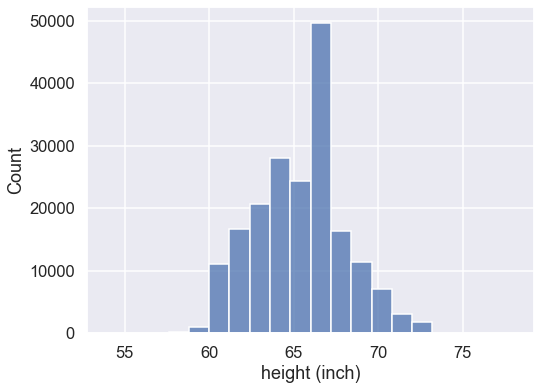

In [33]:
# overview of the whole distribution of height
plt.figure(figsize=(8, 6))
sns.histplot(data=df,x = 'height', bins=20)
plt.xlabel('height (inch)')
plt.show()

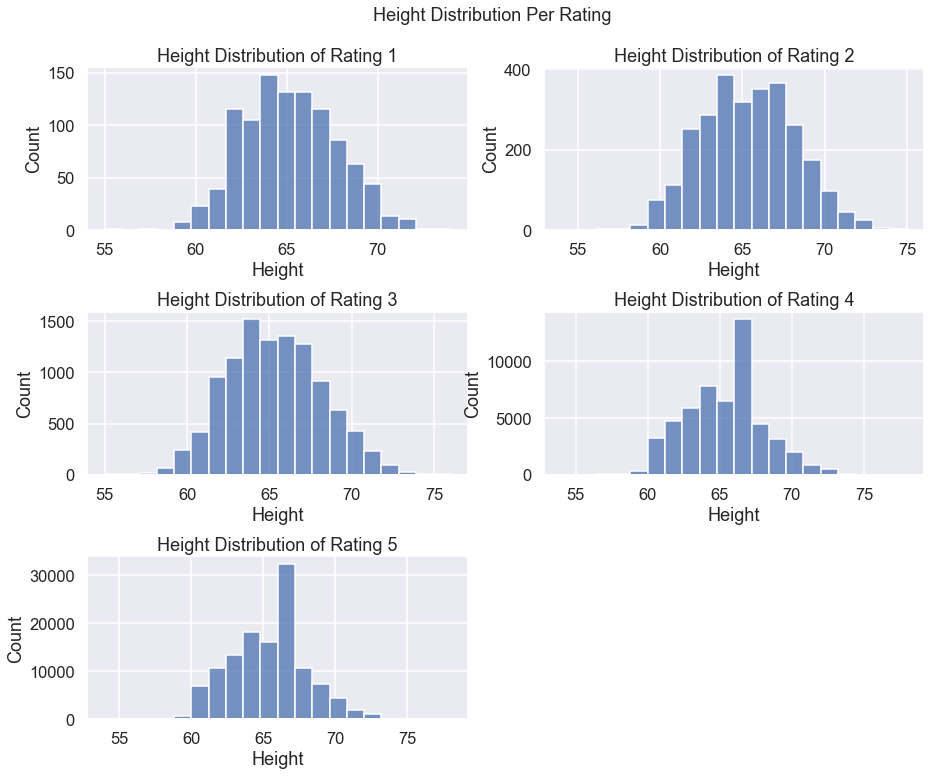

In [34]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
axs = axs.flat
axs[-1].remove()
axs = axs[:-1]
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Height Distribution Per Rating", fontsize=18, y=0.95)

for ax, gb in zip(axs, df.groupby('rating')):
    rate, dfs = gb
    sns.histplot(data = dfs,x = 'height', bins=20, ax = ax)
    ax.set_title(f'Height Distribution of Rating {int(rate)}')
    ax.set_xlabel("Height")
plt.show()

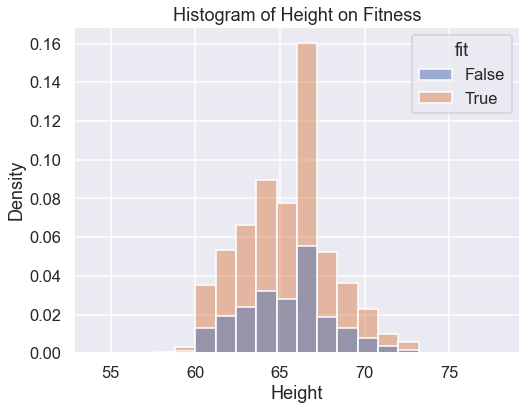

In [35]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="height", hue="fit", bins=20, stat="density").set(title='Histogram of Height on Fitness', xlabel = 'Height')
plt.show()

### Weights

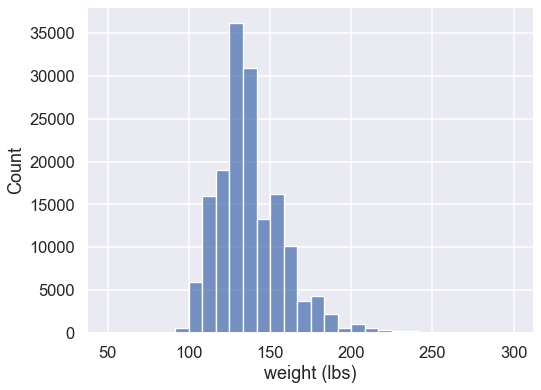

In [36]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x = 'weight', bins=30)
plt.xlabel('weight (lbs)')
plt.show()

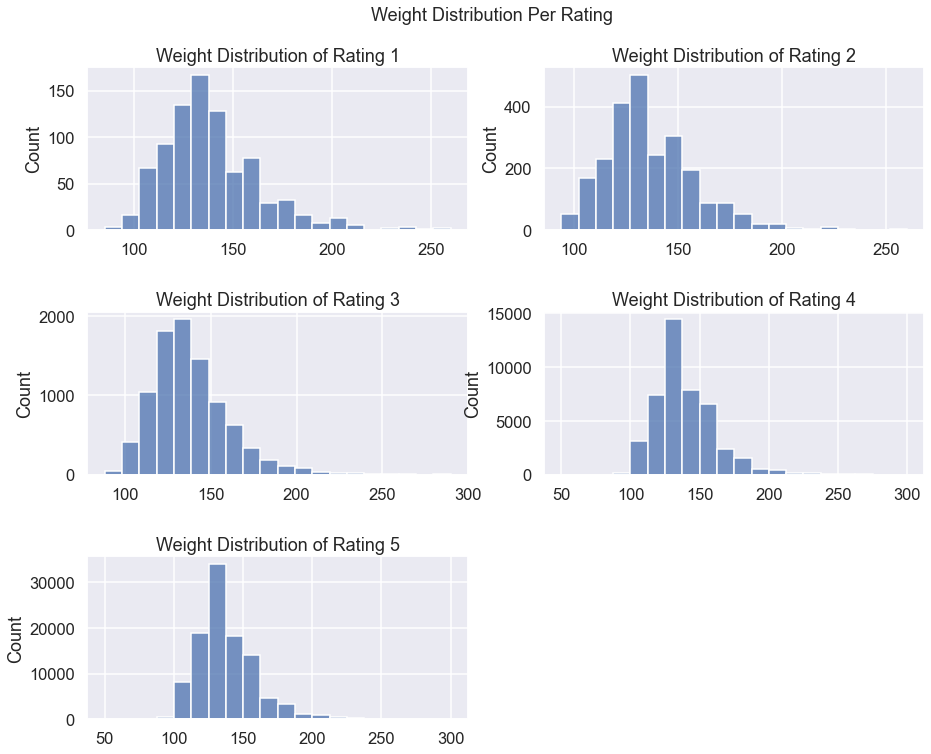

In [37]:
# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
axs = axs.flat
axs[-1].remove()
axs = axs[:-1]
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Weight Distribution Per Rating", fontsize=18, y=0.95)

# loop through tickers and axes
for gb, ax in zip(df.groupby('rating'), axs.ravel()):
    rate, dfs = gb
    sns.histplot(data = dfs,x = 'weight', bins=20, ax = ax)
    ax.set_title(f'Weight Distribution of Rating {int(rate)}')
    ax.set_xlabel("")

plt.show()

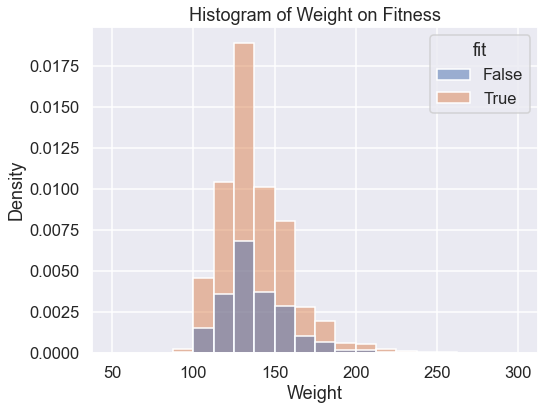

In [38]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="weight", hue="fit", bins=20, stat="density").set(title='Histogram of Weight on Fitness', xlabel = 'Weight')
plt.show()

### Category data and standardize date

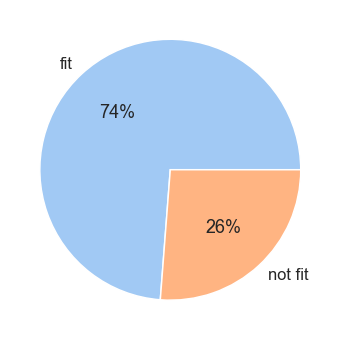

In [47]:
data = df['fit'].value_counts().tolist()
labels = ['fit', 'not fit']
colors = sns.color_palette('pastel')[0:2]
plt.figure(figsize=(8, 6))
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

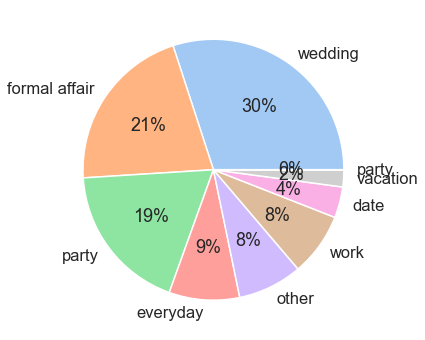

In [48]:
data = df['rented for'].value_counts().tolist()
labels = ['wedding', 'formal affair', 'party', 'everyday', 'other', 'work', 'date', 'vacation', 'party']
colors = sns.color_palette('pastel')[0:9]
plt.figure(figsize=(8, 6))
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [41]:
df['body type'].value_counts()

hourglass            55349
athletic             43667
pear                 22135
petite               22131
full bust            15006
straight & narrow    14742
apple                 4877
Name: body type, dtype: int64

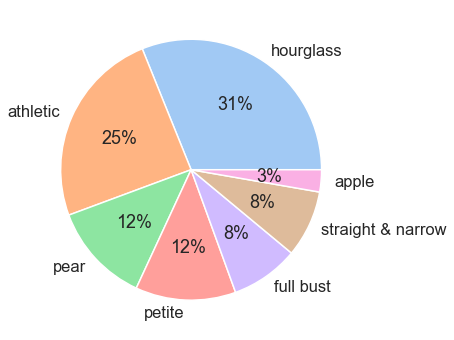

In [49]:
data = df['body type'].value_counts().tolist()
labels = ['hourglass', 'athletic', 'pear', 'petite', 'full bust', 'straight & narrow', 'apple']
colors = sns.color_palette('pastel')[0:7]
plt.figure(figsize=(8, 6))
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [50]:
df_date = df["review_date"].apply(lambda x : pd.to_datetime(x))
min_date = min(df_date)
date_diff = (df_date - min_date).astype(str).apply(lambda x : x.split()[0]).astype(int)
std_date_diff = ((date_diff - np.mean(date_diff))/np.std(date_diff))
df['review_date'] = std_date_diff
df.head(5)

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,True,420272,34d,2260466,137.0,5.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28,NaN
1,True,273551,34b,153475,132.0,5.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36,NaN
2,True,360448,NaN,1063761,NaN,5.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,64.0,4,116,NaN
3,True,909926,34c,126335,135.0,4.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34,NaN
4,True,151944,34b,616682,145.0,5.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27,NaN


### Bust size???????

In [51]:
df['bust size'].unique()

array(['34d', '34b', nan, '34c', '32b', '34d+', '36d', '36a', '32d+',
       '36c', '32c', '32dd', '30dd', '32d', '36b', '34a', '34dd',
       '40ddd/e', '32a', '38d+', '38c', '34ddd/e', '38a', '38b', '38d',
       '36ddd/e', '38dd', '38f', '42dd', '36dd', '40g', '40dd', '28f',
       '30ddd/e', '32ddd/e', '28b', '36d+', '40d', '28dd', '34f', '42c',
       '30d', '30b', '42d', '34aa', '32aa', '36f', '28c', '40b', '36aa',
       '34g', '32f', '42ddd/e', '40c', '28g', '28aa', '36g', '30a',
       '44ddd/e', '30c', '30aa', '44dd', '32i', '32g', '30g', '38h',
       '30h', '34j', '38ddd/e', '32h', '28a', '44d', '40h', '38g', '34h',
       '36j', '40f', '36h', '28ddd/e', '44f', '34i', '30f', '36i', '30i',
       '28h', '42b', '42j', '32j', '46c', '48d', '38aa', '38i', '48dd',
       '28d', '28i', '46ddd/e', '42g', '44c', '42f', '40j', '38j', '46f',
       '44b', '44g', '42h', '40i', '44h'], dtype=object)

### Cloth Category

In [52]:
most_common_cat = df['category'].value_counts()[:9].index.tolist()
cnt_cat = []
for i in most_common_cat:
    cnt_cat.append(len(df[df['category'] == i]))
most_common_cat.append('other')
cnt_cat.append(len(df) - sum(cnt_cat))

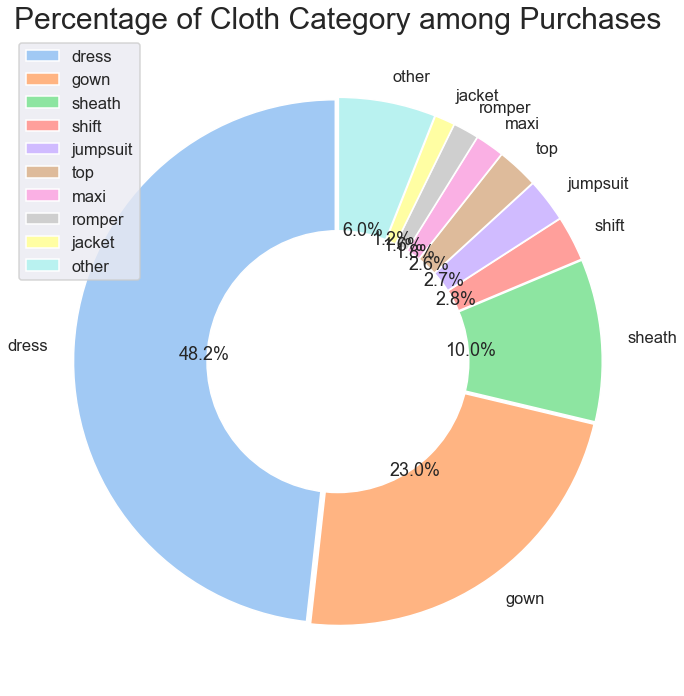

In [54]:
fig = plt.figure(figsize=(10, 20))
colors = sns.color_palette('pastel')[0:10]
explode = [0.01] * len(most_common_cat)
plt.pie(cnt_cat, labels = most_common_cat, colors=colors,autopct='%1.1f%%',startangle=90, pctdistance=0.5, explode = explode)
centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle) 
plt.tight_layout()
plt.legend()
plt.title("Percentage of Cloth Category among Purchases",fontsize=30)
plt.show()